# Projeto 3: Segmentação de clientes no ecommerce


Realizar uma segmentação de clientes aplicando a metodologia RFM para um e-commerce.

# 1 - Contexto
 
O dataset utilizado neste notebook pode ser obtido [nesse projeto no Kaggle](https://www.kaggle.com/datasets/datacertlaboratoria/projeto-3-segmentao-de-clientes-no-ecommerce).





Este notebook está divido em 4 partes:

### Pré processamento dos dados

- Revisar a qualidade do banco de dados, remover dados duplicados que não façam sentido, encontrar dados ausentes e substituí-los/removê-los e procurar dados não correspondentes (por exemplo, números negativos em colunas que normalmente são números positivos). 

- O pré-processamento dos dados é uma etapa fundamental e básica em todas as análises de dados.

O item 2 neste notebook abrangerá essa parte.

### Análise Exploratória

- Utilizar uma ferramenta de visualização, no caso o Google Data Studio, e fazer gráficos, resumir e estruturar as informações mais relevantes.

- A ideia é poder mostrar visualmente as principais características do conjunto de dados, com foco em métricas de vendas como as listadas por seu chefe no briefing.

O item 3 irá auxiliar na criação dos gráficos.

### Análise de Coorte

- Aplicar uma análise de coorte para clientes britânicos e estrangeiros para ver qual dos dois públicos tem os clientes mais leais.

O item 4 neste notebook irá gerar o gráfico de coorte dos clientes.

### Segmentação de clientes

- Segmentar seus clientes com base em três características: Recência, Frequência e Valor Monetário.

O item 5 irá apresentar a segmentação dos clientes e terá como resultado a categorização deles.

Como resultado final será gerado um arquivo CSV para apoio nas análises em ferramentas de visualização.

# 2 - Importar, entender o dataset e limpar os dados

## Importando as bibliotecas 

As bibliotecas utilizadas neste projeto são: [Pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), [NumPy](https://numpy.org/).

In [43]:
%pip install --upgrade xlrd

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [45]:
print('Versão do Pandas -> %s' % pd.__version__)
print('Versão do Numpy -> %s' % np.__version__)
print('Versão do Seaborn -> %s' % sns.__version__)



Versão do Pandas -> 1.3.4
Versão do Numpy -> 1.20.3
Versão do Seaborn -> 0.11.2


In [46]:
#import warnings
#warnings.filterwarnings('ignore')

In [47]:

df = pd.read_csv("./dados/vendas-por-fatura.csv")

Analisando o dataset importado

In [48]:
df.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,3/30/2021 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,11/11/2021 11:11:00,17348.0,United Kingdom,163,"209,73"
2,C570727,10/12/2021 11:32:00,12471.0,Germany,-1,"-1,45"
3,549106,4/6/2021 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,10/27/2021 15:33:00,16416.0,United Kingdom,357,"344,83"


In [49]:
df.columns

Index(['N° da fatura', 'Data da fatura', 'ID Cliente', 'País', 'Quantidade',
       'Valor'],
      dtype='object')

O dataset possui as 6 colunas: 'N° da fatura', 'Data da fatura', 'ID Cliente', 'País', 'Quantidade' e 'Valor' referente as faturas criadas sobre as vendas para os clientes.

Iremos renomear as colunas para facilitar a sua manipulação.

In [50]:
# Renomeando as colunas
df.columns = df.columns.str.replace(" ", "_")
df.columns

Index(['N°_da_fatura', 'Data_da_fatura', 'ID_Cliente', 'País', 'Quantidade',
       'Valor'],
      dtype='object')

Agora iremos analisar os tipos de dados:

In [51]:
# analisando os tipos de dados 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25953 entries, 0 to 25952
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   N°_da_fatura    25953 non-null  object 
 1   Data_da_fatura  25953 non-null  object 
 2   ID_Cliente      22229 non-null  float64
 3   País            25953 non-null  object 
 4   Quantidade      25953 non-null  int64  
 5   Valor           25953 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


## 2.1 - Detecção de nulos ou vazios

É possível analisar que existem apenas 22229 linhas com dados sobre 'ID Cliente' enquanto há 25953 linhas preenchidas referente as outras colunas. Ou seja, temos que existem 3.724 registros que não conseguimos identificar quem é o cliente. 

Como desejamos realizar a análise de coorte, é muito importante termos certeza que **NÃO** estaremos contabilizando clientes repetidos. Por isso, iremos remover esses registros com 'ID Cliente' nulos.

In [52]:
# Removendo linhas com registro nulo na coluna 'ID_Cliente'
df = df.dropna(subset=["ID_Cliente"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22229 entries, 0 to 25951
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   N°_da_fatura    22229 non-null  object 
 1   Data_da_fatura  22229 non-null  object 
 2   ID_Cliente      22229 non-null  float64
 3   País            22229 non-null  object 
 4   Quantidade      22229 non-null  int64  
 5   Valor           22229 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [53]:
# verificando se existem valores nulos
temp = df.isnull().values.any()
temp

False

Também é possível validar que não há campos nulos em nenhuma das colunas existentes.

## 2.2 Detecção e remoção de dados duplicados

In [54]:
# Removendo os dados duplicados do dataset
df.drop_duplicates(inplace=True)

df.shape

(22221, 6)

Foram identificadas e removidas 8 linhas duplicadas. Após isso temos 22221 registros únicos no nosso dataset.

## 2.3 Detecção e eliminação de quantidades negativas

Como as faturas que iniciam com a letra 'C' correspondem a devolução e desejamos analisar as vendas do negócio, então iremos identificar e remover esses valores do nosso dataset.

In [55]:
devolucao = df['N°_da_fatura'].str.startswith('C')
df[devolucao].head()


,N°_da_fatura,Data_da_fatura,ID_Cliente,País,Quantidade,Valor
2,C570727,10/12/2021 11:32:00,12471.0,Germany,-1,"-1,45"
10,C543628,2/10/2021 15:51:00,16558.0,United Kingdom,-5,"-9,25"
17,C553508,5/17/2021 13:44:00,14000.0,United Kingdom,-3,"-1,95"
20,C577693,11/21/2021 11:48:00,12628.0,Germany,-3,"-16,85"
22,C547309,3/22/2021 11:17:00,17416.0,United Kingdom,-12,"-45,00"


In [56]:
df[devolucao].shape

(3655, 6)

Foram identificadas 3655 compras que tiveram devolução, sendo assim elas serão removidas do dataset.

In [57]:
df.drop(df[devolucao].index, inplace=True)
df.head()

,N°_da_fatura,Data_da_fatura,ID_Cliente,País,Quantidade,Valor
0,548370,3/30/2021 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,11/11/2021 11:11:00,17348.0,United Kingdom,163,"209,73"
3,549106,4/6/2021 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,10/27/2021 15:33:00,16416.0,United Kingdom,357,"344,83"
5,576630,11/16/2021 8:38:00,13816.0,Germany,91,"199,98"


In [58]:
df.shape

(18566, 6)

Como resultado temos 18566 registros após aplicar a limpeza nos dados.

## Tratando os dados

Agora iremos realizar os tratamentos necessários para realizar as avaliações e cálculos necessários.

In [59]:
# Convertendo para tipo inteiro o 'ID_Cliente'
df['ID_Cliente'] = df['ID_Cliente'].astype(int)

In [60]:
# Convertendo tipo da 'Data da Fatura' para data
df["Data_da_fatura"] = pd.to_datetime(df["Data_da_fatura"])

In [61]:
# Ordenando pela Data da Fatura de maneira ascendente
df.sort_values(by=['Data_da_fatura'], inplace=True)
df.head()


,N°_da_fatura,Data_da_fatura,ID_Cliente,País,Quantidade,Valor
9367,536365,2020-12-01 08:26:00,17850,United Kingdom,40,"139,12"
18259,536366,2020-12-01 08:28:00,17850,United Kingdom,12,"22,20"
11185,536368,2020-12-01 08:34:00,13047,United Kingdom,15,"70,05"
6876,536367,2020-12-01 08:34:00,13047,United Kingdom,83,"278,73"
8195,536369,2020-12-01 08:35:00,13047,United Kingdom,3,"17,85"


In [62]:
# alterando a separação dos valores de ',' para '.' na coluna Valor
df['Valor'] = df['Valor'].str.replace(",", ".")
df.head()

,N°_da_fatura,Data_da_fatura,ID_Cliente,País,Quantidade,Valor
9367,536365,2020-12-01 08:26:00,17850,United Kingdom,40,139.12
18259,536366,2020-12-01 08:28:00,17850,United Kingdom,12,22.20
11185,536368,2020-12-01 08:34:00,13047,United Kingdom,15,70.05
6876,536367,2020-12-01 08:34:00,13047,United Kingdom,83,278.73
8195,536369,2020-12-01 08:35:00,13047,United Kingdom,3,17.85


In [63]:
# alterando o tipo da coluna 'Valor' para float
df['Valor'] = pd.to_numeric(df['Valor'])
df.head()


,N°_da_fatura,Data_da_fatura,ID_Cliente,País,Quantidade,Valor
9367,536365,2020-12-01 08:26:00,17850,United Kingdom,40,139.12
18259,536366,2020-12-01 08:28:00,17850,United Kingdom,12,22.20
11185,536368,2020-12-01 08:34:00,13047,United Kingdom,15,70.05
6876,536367,2020-12-01 08:34:00,13047,United Kingdom,83,278.73
8195,536369,2020-12-01 08:35:00,13047,United Kingdom,3,17.85


In [64]:
# Obtendo Ano e Mês
df['Ano_mes'] = df['Data_da_fatura'].dt.to_period('M')
df.head()

,N°_da_fatura,Data_da_fatura,ID_Cliente,País,Quantidade,Valor,Ano_mes
9367,536365,2020-12-01 08:26:00,17850,United Kingdom,40,139.12,2020-12
18259,536366,2020-12-01 08:28:00,17850,United Kingdom,12,22.20,2020-12
11185,536368,2020-12-01 08:34:00,13047,United Kingdom,15,70.05,2020-12
6876,536367,2020-12-01 08:34:00,13047,United Kingdom,83,278.73,2020-12
8195,536369,2020-12-01 08:35:00,13047,United Kingdom,3,17.85,2020-12


In [65]:
# Classificando se o cliente pertence ou não ao Reino Unido
df.loc[df['País']=="United Kingdom", 'Pertence_UK'] = "SIM"
df.loc[df['País']!="United Kingdom", 'Pertence_UK'] = "NÃO"
df.head(10)

,N°_da_fatura,Data_da_fatura,ID_Cliente,País,Quantidade,Valor,Ano_mes,Pertence_UK
9367,536365,2020-12-01 08:26:00,17850,United Kingdom,40,139.12,2020-12,SIM
18259,536366,2020-12-01 08:28:00,17850,United Kingdom,12,22.20,2020-12,SIM
11185,536368,2020-12-01 08:34:00,13047,United Kingdom,15,70.05,2020-12,SIM
6876,536367,2020-12-01 08:34:00,13047,United Kingdom,83,278.73,2020-12,SIM
8195,536369,2020-12-01 08:35:00,13047,United Kingdom,3,17.85,2020-12,SIM
505,536370,2020-12-01 08:45:00,12583,France,449,855.86,2020-12,NÃO
12932,536371,2020-12-01 09:00:00,13748,United Kingdom,80,204.00,2020-12,SIM
2773,536372,2020-12-01 09:01:00,17850,United Kingdom,12,22.20,2020-12,SIM
20456,536373,2020-12-01 09:02:00,17850,United Kingdom,88,259.86,2020-12,SIM
24617,536374,2020-12-01 09:09:00,15100,United Kingdom,32,350.40,2020-12,SIM


In [66]:
df.dtypes

N°_da_fatura              object
Data_da_fatura    datetime64[ns]
ID_Cliente                 int32
País                      object
Quantidade                 int64
Valor                    float64
Ano_mes                period[M]
Pertence_UK               object
dtype: object

# 3 - Análise das métricas de vendas

## 3.1 Análise do número de faturas por país

Agora iremos analisar a quantidade total de faturas emitidas por país e a porcentagem de faturas representada por país.

In [67]:
# Quantidade de Fatura por país
df_fatura_pais = pd.DataFrame(df.groupby(['País'])['N°_da_fatura'].count()).reset_index()
df_fatura_pais.columns = ['País', 'N°_de_faturas']
df_fatura_pais.sort_values('N°_de_faturas', ascending=False, inplace=True)
df_fatura_pais.head(6)

,País,N°_de_faturas
35,United Kingdom,16676
14,Germany,457
13,France,390
10,EIRE,261
3,Belgium,98
23,Netherlands,95


In [68]:
#calculando percentual de faturas por país
df_fatura_pais['Percentual_de_faturas_%'] = (df_fatura_pais['N°_de_faturas']/df_fatura_pais['N°_de_faturas'].sum()) * 100
df_fatura_pais['Percentual_de_faturas_%'] = df_fatura_pais['Percentual_de_faturas_%'].round(2)
df_fatura_pais.head(6)

,País,N°_de_faturas,Percentual_de_faturas_%
35,United Kingdom,16676,89.82
14,Germany,457,2.46
13,France,390,2.10
10,EIRE,261,1.41
3,Belgium,98,0.53
23,Netherlands,95,0.51


O *Reino Unido* é o campeão em compras na UK Merch e como a empresa nasceu lá, é bem provável que isso explique o por quê dele estar em primeiro lugar. 

Os próximos 5 países com maior quantidade de compras são Alemanha, França, Irlanda, Bélgica e Holanda, respectivamente.

## 3.2 Análise de valor total por país

Agora iremos incluir o valor médio, o valor mínimo e o valor máximo por país.

In [69]:
# calculando o valor médio, máximo e mínimo das faturas por país
df_valor_medio = pd.DataFrame(df.groupby(['País'])['Valor'].mean()).round(2).reset_index()
df_valor_max = pd.DataFrame(df.groupby(['País'])['Valor'].max()).reset_index()
df_valor_min = pd.DataFrame(df.groupby(['País'])['Valor'].min()).reset_index()

# criando dataframe unindo os valores encontrados
df_valor_pais = pd.merge(df_valor_medio, df_valor_min, on="País")
df_valor_pais = pd.merge(df_valor_pais, df_valor_max, on="País")
df_valor_pais.rename(columns={"Valor_x":"Valor_médio", "Valor_y":"Valor_mínimo", "Valor":"Valor_máximo"}, inplace=True)

In [70]:
df_analise_pais = pd.merge(df_fatura_pais, df_valor_pais, on="País")
df_analise_pais.sort_values('Valor_médio', ascending=False, inplace=True)
df_analise_pais.head(5)

,País,N°_de_faturas,Percentual_de_faturas_%,Valor_médio,Valor_mínimo,Valor_máximo
22,Singapore,7,0.04,3039.90,999.26,6068.06
5,Netherlands,95,0.51,3004.70,0.00,20277.92
7,Australia,57,0.31,2430.20,61.20,22775.93
15,Japan,20,0.11,1870.82,15.30,5735.24
33,Lebanon,1,0.01,1693.88,1693.88,1693.88


In [71]:
df_analise_pais.sort_values('Percentual_de_faturas_%', ascending=False, inplace=True)
df_analise_pais.head(5)

,País,N°_de_faturas,Percentual_de_faturas_%,Valor_médio,Valor_mínimo,Valor_máximo
0,United Kingdom,16676,89.82,438.26,0.00,168469.60
1,Germany,457,2.46,500.80,3.00,9341.26
2,France,390,2.10,535.96,4.63,8895.76
3,EIRE,261,1.41,1017.42,1.45,16774.72
4,Belgium,98,0.53,420.37,34.00,1491.59


O Reino Unido possui um **valor médio de £438,26** por fatura. Esse valor pode ser considerado baixo quando analisamos os 5 maiores valores médios. 

Também percebemos que em alguns países como a Holanda e o Reino Unido apresentam valores mínimos de fatura de £0,00. A partir disso, seria importante identificar se é um erro de lançamento de dados ou se são doações que foram realizadas. 

## 3.3 Faturas geradas por mês

Vamos visualizar qual a quantidade de faturas geradas por mês ao longo do período.

In [72]:
df_fatura_mes = pd.DataFrame(df.groupby(['Ano_mes'])['N°_da_fatura'].count()).reset_index()
df_fatura_mes.rename(columns={"N°_da_fatura": "Quantidade de Faturas"}, inplace=True)
df_fatura_mes

,Ano_mes,Quantidade de Faturas
0,2020-12,1401
1,2021-01,993
2,2021-02,1003
3,2021-03,1324
4,2021-04,1153
5,2021-05,1559
6,2021-06,1394
7,2021-07,1331
8,2021-08,1283
9,2021-09,1757


Para facilitar a nossa visualização, vamos apresentar esses dados em um gráfico de linha. 

Text(0.5, 1.0, 'Total de faturas por mês')

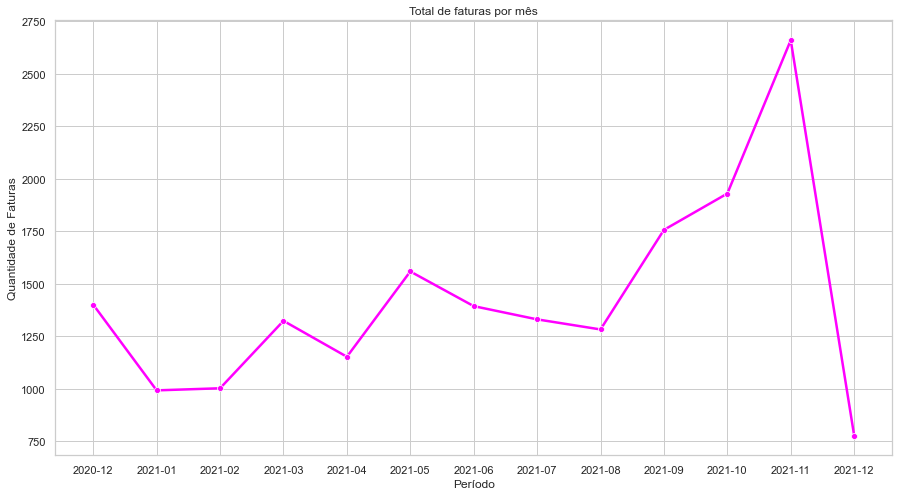

In [152]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (15,8))
qtd_fatura = sns.lineplot(data=df_fatura_mes, x="Ano_mes", y="Quantidade de Faturas", color="magenta",   linewidth=2.5, marker="o")
qtd_fatura.set_xlabel('Período')
qtd_fatura.set_title('Total de faturas por mês')


# Análise de Coorte

Aqui vai ser apresentado a análise de coorte dos clientes.

In [75]:
# contando clientes únicos por ano/mês
df_coorte = pd.DataFrame(df.groupby(['Ano_mes'])['ID_Cliente'].nunique()).reset_index()
df_coorte

,Ano_mes,ID_Cliente
0,2020-12,885
1,2021-01,741
2,2021-02,758
3,2021-03,974
4,2021-04,856
5,2021-05,1056
6,2021-06,991
7,2021-07,949
8,2021-08,935
9,2021-09,1266


# 5 - Segmentação de clientes

Aqui será realizada a categorização dos clientes.


# Salvando os dados tratados para criação de análises no Google Data Studio

In [76]:
#alterando o tipo para string nas colunas que representam moeda nos dataframes para facilitar a manipulação no Google Sheets
df['Valor'] = df['Valor'].astype(str)

# alterando a separação dos valores de '.' para ',' na coluna Valor para facilitar conversão em moeda no Google Sheets
df['Valor'] = df['Valor'].str.replace(".", ",")

C:\Users\carla\AppData\Local\Temp/ipykernel_7568/1801186074.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Valor'] = df['Valor'].str.replace(".", ",")


In [77]:
df_analise_pais['Valor_médio'] = (df_analise_pais['Valor_médio']).astype(str)
df_analise_pais['Valor_mínimo'] = (df_analise_pais['Valor_mínimo']).astype(str)
df_analise_pais['Valor_máximo'] = (df_analise_pais['Valor_máximo']).astype(str)

df_analise_pais['Valor_médio'] = df_analise_pais['Valor_médio'].str.replace(".", ",")
df_analise_pais['Valor_mínimo'] = df_analise_pais['Valor_mínimo'].str.replace(".", ",")
df_analise_pais['Valor_máximo'] = df_analise_pais['Valor_máximo'].str.replace(".", ",")

C:\Users\carla\AppData\Local\Temp/ipykernel_7568/2760267649.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_analise_pais['Valor_médio'] = df_analise_pais['Valor_médio'].str.replace(".", ",")
C:\Users\carla\AppData\Local\Temp/ipykernel_7568/2760267649.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_analise_pais['Valor_mínimo'] = df_analise_pais['Valor_mínimo'].str.replace(".", ",")
C:\Users\carla\AppData\Local\Temp/ipykernel_7568/2760267649.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_analise_pais[

In [78]:
# Salvando arquivo csv dos dados tratados 
diretorio = "./dados/dados-tratados.csv"
df.to_csv(diretorio, sep=';', index=False, encoding='ISO-8859-1')

In [79]:
# Salvando arquivo csv das métricas geradas no item 3.2
diretorio = "./dados/analise-vendas-pais.csv"
df_analise_pais.to_csv(diretorio, sep=';', index=False, encoding='ISO-8859-1')